<a href="https://colab.research.google.com/github/varunyadav17/FashionMNIST_with_GAN/blob/master/FashinMNISTGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input, Reshape
from keras.layers import Flatten, Dense, LeakyReLU
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt

In [0]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    
    optimizer = Adam(0.0002, 0.5)
    
    # Build and compile discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    # Build the generator
    self.generator = self.build_generator()
    
    # Generator takes noise as input and generates images
    z = Input(shape = (self.latent_dim,))
    img = self.generator(z)
    
    self.discriminator.trainable = False
    
    validity = self.discriminator(img)
    
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    
  def build_generator(self):
    model = Sequential()
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(np.prod(self.img_shape), activation = 'tanh'))
    model.add(Reshape(self.img_shape))
    
    model.summary()
    
    noise = Input(shape = (self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
    
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    
    img = Input(shape = self.img_shape)
    validity = model(img)
    
    return Model(img, validity)
  
  def train(self, epochs, batch_size = 128, sample_interval = 50):
    (X_train,_), (_,_) = fashion_mnist.load_data()
    X_train = X_train/127.5 - 1
    X_train = np.expand_dims(X_train, axis = 3)
    
    # Adversial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
      
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      
      # Generate a batch of new images
      gen_imgs = self.generator.predict(noise)

      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      g_loss = self.combined.train_on_batch(noise, valid)
      
      print("%d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      
      if epoch % sample_interval == 0:
        self.sample_images(epoch)
        
  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r *c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Rescale images 0 to 1
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
        axs[i, j].axis('off')
        cnt += 1
        
    plt.show()
    plt.close()
    

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.828803, acc.:28.12%] [G loss: 0.649942]


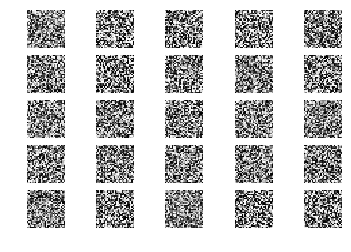

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.468267, acc.:70.31%] [G loss: 0.739277]
2 [D loss: 0.413227, acc.:76.56%] [G loss: 0.812613]
3 [D loss: 0.302080, acc.:90.62%] [G loss: 0.920024]
4 [D loss: 0.273797, acc.:87.50%] [G loss: 1.017359]
5 [D loss: 0.271028, acc.:96.88%] [G loss: 1.227269]
6 [D loss: 0.212763, acc.:98.44%] [G loss: 1.342415]
7 [D loss: 0.173317, acc.:100.00%] [G loss: 1.487433]
8 [D loss: 0.187369, acc.:100.00%] [G loss: 1.488094]
9 [D loss: 0.153582, acc.:100.00%] [G loss: 1.636861]
10 [D loss: 0.143426, acc.:100.00%] [G loss: 1.800157]
11 [D loss: 0.107434, acc.:100.00%] [G loss: 1.861451]
12 [D loss: 0.127358, acc.:100.00%] [G loss: 1.822838]
13 [D loss: 0.092863, acc.:100.00%] [G loss: 1.929562]
14 [D loss: 0.101197, acc.:100.00%] [G loss: 2.063742]
15 [D loss: 0.104992, acc.:100.00%] [G loss: 2.062357]
16 [D loss: 0.084555, acc.:100.00%] [G loss: 2.204543]
17 [D loss: 0.088556, acc.:98.44%] [G loss: 2.291404]
18 [D loss: 0.075487, acc.:100.00%] [G loss: 2.315801]
19 [D loss: 0.069938, acc.

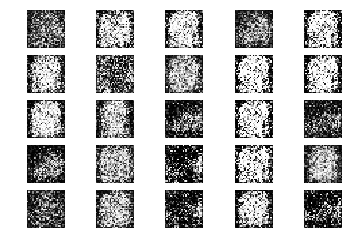

201 [D loss: 0.317426, acc.:85.94%] [G loss: 3.309024]
202 [D loss: 0.180476, acc.:95.31%] [G loss: 3.289950]
203 [D loss: 0.360986, acc.:81.25%] [G loss: 3.396085]
204 [D loss: 0.396016, acc.:84.38%] [G loss: 3.392556]
205 [D loss: 0.158195, acc.:93.75%] [G loss: 3.521198]
206 [D loss: 0.333904, acc.:84.38%] [G loss: 3.629127]
207 [D loss: 0.243650, acc.:95.31%] [G loss: 3.614021]
208 [D loss: 0.338826, acc.:84.38%] [G loss: 3.683061]
209 [D loss: 0.669612, acc.:68.75%] [G loss: 2.924806]
210 [D loss: 0.281382, acc.:84.38%] [G loss: 3.339686]
211 [D loss: 0.453536, acc.:84.38%] [G loss: 3.718778]
212 [D loss: 0.367390, acc.:84.38%] [G loss: 2.467636]
213 [D loss: 0.384762, acc.:84.38%] [G loss: 3.305482]
214 [D loss: 0.207829, acc.:98.44%] [G loss: 4.066133]
215 [D loss: 0.400059, acc.:81.25%] [G loss: 2.607706]
216 [D loss: 0.359273, acc.:87.50%] [G loss: 3.151194]
217 [D loss: 0.361561, acc.:90.62%] [G loss: 3.447085]
218 [D loss: 0.348657, acc.:81.25%] [G loss: 3.008342]
219 [D los

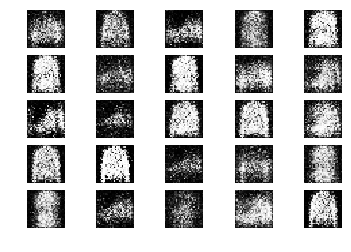

401 [D loss: 0.638361, acc.:60.94%] [G loss: 1.083615]
402 [D loss: 0.630470, acc.:76.56%] [G loss: 1.053230]
403 [D loss: 0.624075, acc.:65.62%] [G loss: 1.107393]
404 [D loss: 0.538930, acc.:70.31%] [G loss: 1.089948]
405 [D loss: 0.623838, acc.:70.31%] [G loss: 0.958740]
406 [D loss: 0.628797, acc.:70.31%] [G loss: 1.008176]
407 [D loss: 0.623676, acc.:57.81%] [G loss: 1.129359]
408 [D loss: 0.604370, acc.:67.19%] [G loss: 1.104315]
409 [D loss: 0.522940, acc.:78.12%] [G loss: 1.012257]
410 [D loss: 0.623444, acc.:60.94%] [G loss: 1.069454]
411 [D loss: 0.615335, acc.:62.50%] [G loss: 1.043252]
412 [D loss: 0.578179, acc.:71.88%] [G loss: 1.031016]
413 [D loss: 0.653543, acc.:67.19%] [G loss: 0.938734]
414 [D loss: 0.648809, acc.:68.75%] [G loss: 0.954887]
415 [D loss: 0.652721, acc.:68.75%] [G loss: 0.870710]
416 [D loss: 0.701644, acc.:54.69%] [G loss: 0.956450]
417 [D loss: 0.604355, acc.:68.75%] [G loss: 0.968876]
418 [D loss: 0.602839, acc.:71.88%] [G loss: 1.020635]
419 [D los

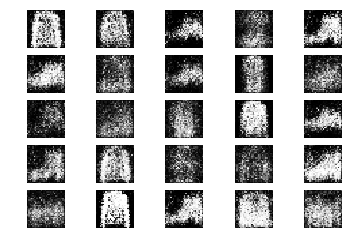

601 [D loss: 0.659396, acc.:64.06%] [G loss: 0.892379]
602 [D loss: 0.579803, acc.:70.31%] [G loss: 0.897276]
603 [D loss: 0.577222, acc.:76.56%] [G loss: 0.950079]
604 [D loss: 0.708519, acc.:64.06%] [G loss: 1.054744]
605 [D loss: 0.627700, acc.:67.19%] [G loss: 0.956069]
606 [D loss: 0.658928, acc.:60.94%] [G loss: 0.931385]
607 [D loss: 0.611834, acc.:70.31%] [G loss: 1.024264]
608 [D loss: 0.627219, acc.:60.94%] [G loss: 0.933616]
609 [D loss: 0.686404, acc.:64.06%] [G loss: 0.886688]
610 [D loss: 0.620773, acc.:65.62%] [G loss: 0.841649]
611 [D loss: 0.627586, acc.:62.50%] [G loss: 0.924727]
612 [D loss: 0.671093, acc.:54.69%] [G loss: 0.885743]
613 [D loss: 0.654869, acc.:57.81%] [G loss: 0.987954]
614 [D loss: 0.690188, acc.:56.25%] [G loss: 0.962308]
615 [D loss: 0.545958, acc.:76.56%] [G loss: 0.984261]
616 [D loss: 0.676674, acc.:56.25%] [G loss: 0.881021]
617 [D loss: 0.671351, acc.:50.00%] [G loss: 0.895332]
618 [D loss: 0.674477, acc.:59.38%] [G loss: 1.077069]
619 [D los

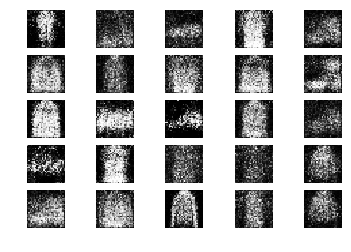

801 [D loss: 0.580767, acc.:68.75%] [G loss: 0.921592]
802 [D loss: 0.627830, acc.:68.75%] [G loss: 0.923280]
803 [D loss: 0.560413, acc.:73.44%] [G loss: 0.904179]
804 [D loss: 0.634997, acc.:57.81%] [G loss: 1.055732]
805 [D loss: 0.697418, acc.:56.25%] [G loss: 0.963810]
806 [D loss: 0.584299, acc.:73.44%] [G loss: 0.967225]
807 [D loss: 0.556960, acc.:68.75%] [G loss: 0.922040]
808 [D loss: 0.534921, acc.:75.00%] [G loss: 1.001426]
809 [D loss: 0.652733, acc.:54.69%] [G loss: 0.889232]
810 [D loss: 0.628335, acc.:68.75%] [G loss: 0.984343]
811 [D loss: 0.582589, acc.:73.44%] [G loss: 0.916230]
812 [D loss: 0.671328, acc.:59.38%] [G loss: 0.841600]
813 [D loss: 0.652590, acc.:60.94%] [G loss: 0.872331]
814 [D loss: 0.662920, acc.:64.06%] [G loss: 0.959024]
815 [D loss: 0.587885, acc.:75.00%] [G loss: 0.892556]
816 [D loss: 0.609867, acc.:68.75%] [G loss: 0.950266]
817 [D loss: 0.648121, acc.:59.38%] [G loss: 0.960387]
818 [D loss: 0.576179, acc.:67.19%] [G loss: 1.012772]
819 [D los

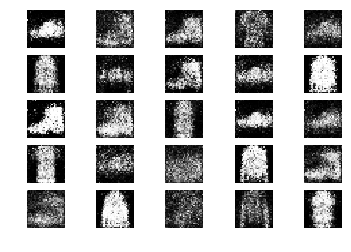

1001 [D loss: 0.703425, acc.:53.12%] [G loss: 0.907554]
1002 [D loss: 0.648770, acc.:59.38%] [G loss: 0.946433]
1003 [D loss: 0.672859, acc.:56.25%] [G loss: 0.908669]
1004 [D loss: 0.668555, acc.:60.94%] [G loss: 0.884477]
1005 [D loss: 0.654189, acc.:54.69%] [G loss: 0.977908]
1006 [D loss: 0.592284, acc.:65.62%] [G loss: 0.930816]
1007 [D loss: 0.598305, acc.:71.88%] [G loss: 0.985430]
1008 [D loss: 0.637397, acc.:57.81%] [G loss: 0.973572]
1009 [D loss: 0.637566, acc.:62.50%] [G loss: 0.885923]
1010 [D loss: 0.642968, acc.:62.50%] [G loss: 0.928502]
1011 [D loss: 0.619023, acc.:60.94%] [G loss: 0.880605]
1012 [D loss: 0.572334, acc.:71.88%] [G loss: 0.873534]
1013 [D loss: 0.622977, acc.:62.50%] [G loss: 0.887188]
1014 [D loss: 0.595062, acc.:70.31%] [G loss: 0.923191]
1015 [D loss: 0.693068, acc.:57.81%] [G loss: 0.845627]
1016 [D loss: 0.657210, acc.:64.06%] [G loss: 0.909083]
1017 [D loss: 0.649257, acc.:64.06%] [G loss: 0.878992]
1018 [D loss: 0.666409, acc.:54.69%] [G loss: 0.

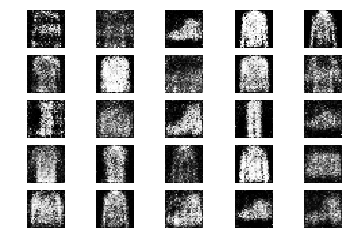

1201 [D loss: 0.657665, acc.:62.50%] [G loss: 0.813824]
1202 [D loss: 0.635077, acc.:57.81%] [G loss: 0.873327]
1203 [D loss: 0.623539, acc.:67.19%] [G loss: 0.815241]
1204 [D loss: 0.660770, acc.:56.25%] [G loss: 0.871787]
1205 [D loss: 0.664032, acc.:60.94%] [G loss: 0.876623]
1206 [D loss: 0.612211, acc.:59.38%] [G loss: 0.827085]
1207 [D loss: 0.645411, acc.:62.50%] [G loss: 0.859968]
1208 [D loss: 0.570266, acc.:76.56%] [G loss: 0.874785]
1209 [D loss: 0.655690, acc.:57.81%] [G loss: 0.829871]
1210 [D loss: 0.671647, acc.:57.81%] [G loss: 0.888281]
1211 [D loss: 0.632927, acc.:68.75%] [G loss: 0.920302]
1212 [D loss: 0.597974, acc.:73.44%] [G loss: 0.883074]
1213 [D loss: 0.646818, acc.:64.06%] [G loss: 0.884755]
1214 [D loss: 0.633822, acc.:60.94%] [G loss: 0.875501]
1215 [D loss: 0.641999, acc.:65.62%] [G loss: 0.905715]
1216 [D loss: 0.627685, acc.:67.19%] [G loss: 0.913396]
1217 [D loss: 0.726566, acc.:57.81%] [G loss: 0.943607]
1218 [D loss: 0.665640, acc.:62.50%] [G loss: 0.

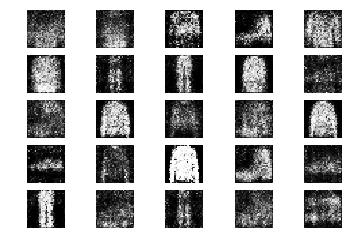

1401 [D loss: 0.655920, acc.:48.44%] [G loss: 0.907344]
1402 [D loss: 0.698642, acc.:57.81%] [G loss: 0.811873]
1403 [D loss: 0.616072, acc.:68.75%] [G loss: 0.894217]
1404 [D loss: 0.682311, acc.:53.12%] [G loss: 0.822434]
1405 [D loss: 0.634539, acc.:64.06%] [G loss: 0.966341]
1406 [D loss: 0.609772, acc.:62.50%] [G loss: 0.854641]
1407 [D loss: 0.671302, acc.:57.81%] [G loss: 0.854170]
1408 [D loss: 0.611228, acc.:60.94%] [G loss: 0.806009]
1409 [D loss: 0.652039, acc.:60.94%] [G loss: 0.794234]
1410 [D loss: 0.620726, acc.:60.94%] [G loss: 0.826194]
1411 [D loss: 0.674383, acc.:62.50%] [G loss: 0.810281]
1412 [D loss: 0.649088, acc.:53.12%] [G loss: 0.837042]
1413 [D loss: 0.646588, acc.:57.81%] [G loss: 0.917982]
1414 [D loss: 0.642761, acc.:65.62%] [G loss: 0.859976]
1415 [D loss: 0.591998, acc.:70.31%] [G loss: 0.843011]
1416 [D loss: 0.644716, acc.:64.06%] [G loss: 0.856481]
1417 [D loss: 0.594619, acc.:70.31%] [G loss: 0.881600]
1418 [D loss: 0.625403, acc.:62.50%] [G loss: 0.

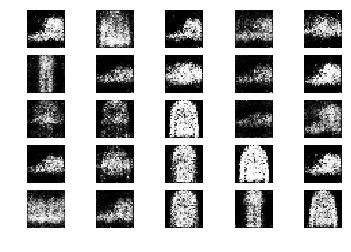

1601 [D loss: 0.593409, acc.:67.19%] [G loss: 0.893298]
1602 [D loss: 0.635711, acc.:68.75%] [G loss: 1.013805]
1603 [D loss: 0.605325, acc.:67.19%] [G loss: 0.971863]
1604 [D loss: 0.677791, acc.:56.25%] [G loss: 0.799832]
1605 [D loss: 0.591364, acc.:68.75%] [G loss: 0.840097]
1606 [D loss: 0.590632, acc.:71.88%] [G loss: 0.777807]
1607 [D loss: 0.611349, acc.:59.38%] [G loss: 0.870877]
1608 [D loss: 0.634753, acc.:64.06%] [G loss: 0.865913]
1609 [D loss: 0.617643, acc.:60.94%] [G loss: 0.824038]
1610 [D loss: 0.684997, acc.:59.38%] [G loss: 0.832554]
1611 [D loss: 0.680257, acc.:53.12%] [G loss: 0.942346]
1612 [D loss: 0.664776, acc.:57.81%] [G loss: 0.798803]
1613 [D loss: 0.623775, acc.:67.19%] [G loss: 0.885376]
1614 [D loss: 0.628265, acc.:71.88%] [G loss: 0.911665]
1615 [D loss: 0.702302, acc.:50.00%] [G loss: 0.941195]
1616 [D loss: 0.622313, acc.:60.94%] [G loss: 0.902919]
1617 [D loss: 0.649061, acc.:64.06%] [G loss: 0.907575]
1618 [D loss: 0.611404, acc.:65.62%] [G loss: 0.

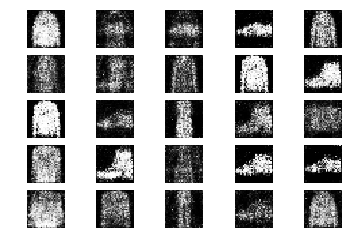

1801 [D loss: 0.647852, acc.:57.81%] [G loss: 0.900235]
1802 [D loss: 0.597817, acc.:67.19%] [G loss: 0.914760]
1803 [D loss: 0.579773, acc.:71.88%] [G loss: 0.880247]
1804 [D loss: 0.575182, acc.:71.88%] [G loss: 0.823446]
1805 [D loss: 0.635128, acc.:62.50%] [G loss: 0.873220]
1806 [D loss: 0.619659, acc.:65.62%] [G loss: 0.954070]
1807 [D loss: 0.685419, acc.:54.69%] [G loss: 0.872889]
1808 [D loss: 0.632335, acc.:64.06%] [G loss: 0.930611]
1809 [D loss: 0.581115, acc.:68.75%] [G loss: 0.960005]
1810 [D loss: 0.551773, acc.:75.00%] [G loss: 0.798986]
1811 [D loss: 0.598250, acc.:68.75%] [G loss: 0.877141]
1812 [D loss: 0.653670, acc.:60.94%] [G loss: 0.917175]
1813 [D loss: 0.643953, acc.:57.81%] [G loss: 0.943591]
1814 [D loss: 0.568984, acc.:71.88%] [G loss: 0.853001]
1815 [D loss: 0.570699, acc.:76.56%] [G loss: 0.906735]
1816 [D loss: 0.562358, acc.:76.56%] [G loss: 0.867078]
1817 [D loss: 0.637742, acc.:64.06%] [G loss: 0.869539]
1818 [D loss: 0.636772, acc.:65.62%] [G loss: 0.

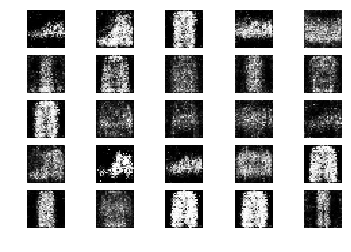

2001 [D loss: 0.628255, acc.:67.19%] [G loss: 0.923281]
2002 [D loss: 0.651239, acc.:57.81%] [G loss: 0.931761]
2003 [D loss: 0.615340, acc.:71.88%] [G loss: 0.973411]
2004 [D loss: 0.641167, acc.:64.06%] [G loss: 1.027514]
2005 [D loss: 0.552598, acc.:78.12%] [G loss: 1.036566]
2006 [D loss: 0.637328, acc.:59.38%] [G loss: 0.969414]
2007 [D loss: 0.586049, acc.:71.88%] [G loss: 0.957344]
2008 [D loss: 0.646814, acc.:56.25%] [G loss: 0.875670]
2009 [D loss: 0.623792, acc.:65.62%] [G loss: 0.935812]
2010 [D loss: 0.653225, acc.:57.81%] [G loss: 0.903032]
2011 [D loss: 0.572689, acc.:68.75%] [G loss: 0.803362]
2012 [D loss: 0.609192, acc.:59.38%] [G loss: 1.003406]
2013 [D loss: 0.602208, acc.:65.62%] [G loss: 0.884213]
2014 [D loss: 0.612796, acc.:59.38%] [G loss: 1.034993]
2015 [D loss: 0.520804, acc.:76.56%] [G loss: 0.916157]
2016 [D loss: 0.686957, acc.:54.69%] [G loss: 0.879997]
2017 [D loss: 0.615866, acc.:71.88%] [G loss: 0.917795]
2018 [D loss: 0.683959, acc.:50.00%] [G loss: 0.

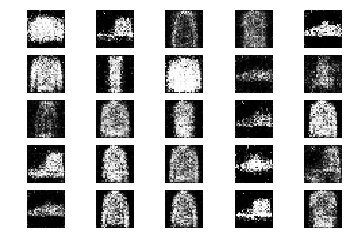

2201 [D loss: 0.595623, acc.:70.31%] [G loss: 0.949912]
2202 [D loss: 0.620358, acc.:60.94%] [G loss: 1.088765]
2203 [D loss: 0.614354, acc.:67.19%] [G loss: 1.007948]
2204 [D loss: 0.614486, acc.:67.19%] [G loss: 1.064167]
2205 [D loss: 0.650411, acc.:65.62%] [G loss: 0.914476]
2206 [D loss: 0.590532, acc.:73.44%] [G loss: 0.963853]
2207 [D loss: 0.649104, acc.:54.69%] [G loss: 0.831759]
2208 [D loss: 0.578223, acc.:68.75%] [G loss: 0.946349]
2209 [D loss: 0.662466, acc.:57.81%] [G loss: 0.864883]
2210 [D loss: 0.621262, acc.:67.19%] [G loss: 0.913094]
2211 [D loss: 0.618167, acc.:65.62%] [G loss: 0.929268]
2212 [D loss: 0.667237, acc.:57.81%] [G loss: 0.957871]
2213 [D loss: 0.733961, acc.:54.69%] [G loss: 1.083354]
2214 [D loss: 0.560647, acc.:75.00%] [G loss: 1.097460]
2215 [D loss: 0.728136, acc.:56.25%] [G loss: 0.906307]
2216 [D loss: 0.672358, acc.:59.38%] [G loss: 0.940921]
2217 [D loss: 0.693278, acc.:51.56%] [G loss: 0.954536]
2218 [D loss: 0.546841, acc.:67.19%] [G loss: 0.

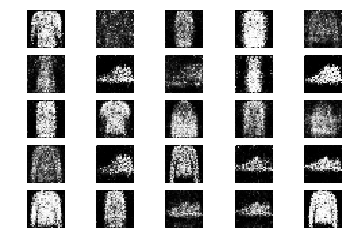

2401 [D loss: 0.540594, acc.:75.00%] [G loss: 1.024529]
2402 [D loss: 0.619045, acc.:70.31%] [G loss: 0.873669]
2403 [D loss: 0.661530, acc.:56.25%] [G loss: 0.976122]
2404 [D loss: 0.584984, acc.:67.19%] [G loss: 0.893129]
2405 [D loss: 0.645428, acc.:57.81%] [G loss: 0.921126]
2406 [D loss: 0.611425, acc.:60.94%] [G loss: 0.924606]
2407 [D loss: 0.666541, acc.:59.38%] [G loss: 1.000328]
2408 [D loss: 0.594328, acc.:67.19%] [G loss: 0.962395]
2409 [D loss: 0.667407, acc.:59.38%] [G loss: 0.930910]
2410 [D loss: 0.637359, acc.:67.19%] [G loss: 0.987576]
2411 [D loss: 0.680562, acc.:54.69%] [G loss: 1.038420]
2412 [D loss: 0.589634, acc.:70.31%] [G loss: 1.008730]
2413 [D loss: 0.607555, acc.:62.50%] [G loss: 0.954526]
2414 [D loss: 0.564173, acc.:75.00%] [G loss: 0.983127]
2415 [D loss: 0.613015, acc.:64.06%] [G loss: 0.987446]
2416 [D loss: 0.574006, acc.:68.75%] [G loss: 1.021657]
2417 [D loss: 0.547799, acc.:73.44%] [G loss: 0.988646]
2418 [D loss: 0.668367, acc.:56.25%] [G loss: 0.

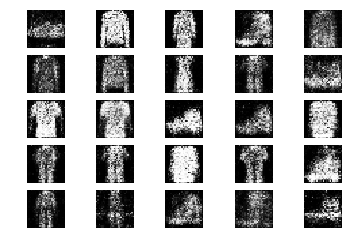

2601 [D loss: 0.612220, acc.:68.75%] [G loss: 0.896526]
2602 [D loss: 0.541125, acc.:78.12%] [G loss: 0.952977]
2603 [D loss: 0.579434, acc.:70.31%] [G loss: 0.835052]
2604 [D loss: 0.674379, acc.:54.69%] [G loss: 0.881485]
2605 [D loss: 0.602530, acc.:70.31%] [G loss: 0.954207]
2606 [D loss: 0.651261, acc.:60.94%] [G loss: 0.893293]
2607 [D loss: 0.640332, acc.:56.25%] [G loss: 0.860224]
2608 [D loss: 0.601343, acc.:67.19%] [G loss: 0.971788]
2609 [D loss: 0.602045, acc.:65.62%] [G loss: 0.889724]
2610 [D loss: 0.688165, acc.:50.00%] [G loss: 0.965440]
2611 [D loss: 0.627269, acc.:59.38%] [G loss: 0.974997]
2612 [D loss: 0.616775, acc.:60.94%] [G loss: 0.956353]
2613 [D loss: 0.586019, acc.:71.88%] [G loss: 0.939080]
2614 [D loss: 0.622742, acc.:67.19%] [G loss: 0.849172]
2615 [D loss: 0.598954, acc.:64.06%] [G loss: 1.015468]
2616 [D loss: 0.634420, acc.:71.88%] [G loss: 1.024348]
2617 [D loss: 0.549828, acc.:73.44%] [G loss: 0.867280]
2618 [D loss: 0.623801, acc.:68.75%] [G loss: 0.

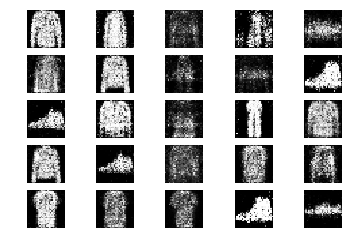

2801 [D loss: 0.677785, acc.:57.81%] [G loss: 0.899775]
2802 [D loss: 0.598396, acc.:71.88%] [G loss: 0.942778]
2803 [D loss: 0.654882, acc.:64.06%] [G loss: 0.941285]
2804 [D loss: 0.615193, acc.:64.06%] [G loss: 0.896696]
2805 [D loss: 0.635760, acc.:65.62%] [G loss: 0.937030]
2806 [D loss: 0.637042, acc.:59.38%] [G loss: 0.871292]
2807 [D loss: 0.655460, acc.:57.81%] [G loss: 0.956211]
2808 [D loss: 0.643659, acc.:64.06%] [G loss: 0.917627]
2809 [D loss: 0.663620, acc.:64.06%] [G loss: 0.889912]
2810 [D loss: 0.675479, acc.:51.56%] [G loss: 0.862158]
2811 [D loss: 0.682388, acc.:57.81%] [G loss: 0.845873]
2812 [D loss: 0.681292, acc.:59.38%] [G loss: 0.825285]
2813 [D loss: 0.649271, acc.:59.38%] [G loss: 0.999356]
2814 [D loss: 0.684227, acc.:57.81%] [G loss: 0.968112]
2815 [D loss: 0.623731, acc.:64.06%] [G loss: 0.898453]
2816 [D loss: 0.614144, acc.:68.75%] [G loss: 1.017680]
2817 [D loss: 0.610575, acc.:60.94%] [G loss: 0.975636]
2818 [D loss: 0.571338, acc.:71.88%] [G loss: 0.

In [0]:
if __name__ == '__main__':
  gan = GAN()
  gan.train(epochs = 3000, batch_size = 32, sample_interval = 200)